Clase del 14 de enero de 2026
Objetivos de aprendizaje (ejercicio):
- Construir una estrategia concreta con opciones: long straddle periódico sobre SPY.
- Modificarla para obtener una versión delta-hedged (usando vuestras griegas) con el subyacente.
- Analizar el P&L histórico de ambas versiones.
- Simular envío de órdenes: como combo (straddle como una sola orden), y como patas sueltas (call y put por separado) analizando el riesgo de legging.
- Ver cómo se puede neutralizar Delta con otra opción y qué implica para Gamma, Vega y Theta.
- Reflexión: ¿qué habría cambiado usando SPX en lugar de SPY?


PUNTO 1: Construir una estrategia concreta con opciones: long straddle periódico sobre SPY.

In [118]:
from ib_insync import IB, util, Stock, Option, ComboLeg, MarketOrder, Contract
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import pandas as pd
from datetime import datetime, timedelta

In [119]:
# ------------------------------------------------------------
# 0) Fix para Spyder/Jupyter: evita "This event loop is already running"
# ------------------------------------------------------------
def ensure_ipython_loop():
    try:
        from IPython import get_ipython
        ip = get_ipython()
        if ip is not None and getattr(ip, "kernel", None) is not None:
            util.startLoop()
    except Exception:
        pass

In [120]:
# ------------------------------------------------------------
# 3) Elegir expiry (~30 días) y strike ATM válido para ese expiry
# ------------------------------------------------------------
def pick_expiry_target(expirations, target_days: int = 30) -> str:
    """
    Elige el expiry más cercano a hoy + target_days (siempre futuro).
    """
    now = datetime.now()
    exp_dt = [(e, datetime.strptime(e, "%Y%m%d")) for e in expirations]
    exp_dt = [(e, d) for e, d in exp_dt if d.date() > now.date()]
    if not exp_dt:
        return sorted(expirations)[-1]
    target = now + timedelta(days=target_days)
    return min(exp_dt, key=lambda x: abs((x[1] - target).days))[0]

def find_valid_atm_strike_for_expiry(
    ib: IB,
    S: float,
    expiry: str,
    strikes,
    multiplier: str,
    trading_class: str,
    exchange: str = "SMART",
    symbol: str = "SPY",
    currency: str = "USD",
    tries: int = 20
) -> tuple[float, Option, Option]:
    """
    Prueba los 'tries' strikes más cercanos al spot y devuelve el primero
    para el que IBKR puede cualificar Call y Put (conId != 0).
    """
    sorted_strikes = sorted(strikes, key=lambda k: abs(float(k) - S))[:tries]

    for K in sorted_strikes:
        K = float(K)
        c = Option(symbol, expiry, K, "C", exchange, currency=currency,
                   multiplier=multiplier, tradingClass=trading_class)
        p = Option(symbol, expiry, K, "P", exchange, currency=currency,
                   multiplier=multiplier, tradingClass=trading_class)

        ib.qualifyContracts(c, p)

        if getattr(c, "conId", 0) not in (0, None) and getattr(p, "conId", 0) not in (0, None):
            return K, c, p

    raise RuntimeError(
        f"No se encontró un strike ATM válido para expiry={expiry} probando {tries} strikes cercanos al spot."
    )


In [121]:
# ------------------------------------------------------------
# 2) Helpers: obtener precio y mid
# ------------------------------------------------------------
def wait_for_price(ib: IB, ticker, timeout_s: float = 10.0) -> float:
    """
    Espera a que ticker.marketPrice() sea válido. Devuelve NaN si no llega.
    """
    steps = int(timeout_s / 0.25)
    px = float("nan")
    for _ in range(max(1, steps)):
        ib.sleep(0.25)
        px = ticker.marketPrice()
        if px is not None and math.isfinite(px) and px > 0:
            return float(px)

    # fallback: last
    if ticker.last is not None and math.isfinite(ticker.last) and ticker.last > 0:
        return float(ticker.last)

    return float("nan")


def mid_price(ticker) -> float:
    """
    Mid = (bid+ask)/2 si existe; si no, last como fallback.
    """
    if ticker.bid is not None and ticker.ask is not None:
        if math.isfinite(ticker.bid) and math.isfinite(ticker.ask) and ticker.bid > 0 and ticker.ask > 0:
            return 0.5 * (ticker.bid + ticker.ask)

    if ticker.last is not None and math.isfinite(ticker.last) and ticker.last > 0:
        return float(ticker.last)

    return float("nan")


def yearfrac_from_yyyymmdd(expiry: str) -> float:
    """
    T aproximado en años: días/365 (suficiente para ejercicio).
    """
    exp_dt = datetime.strptime(expiry, "%Y%m%d")
    days = (exp_dt - datetime.now()).days
    return max(days, 1) / 365.0

def yearfrac_from_dates(start_date, end_date) -> float:
    """
    T aproximado en años basándose en la diferencia entre dos fechas.
    Evita usar datetime.now() para que el backtest sea histórico.
    """
    days = (end_date - start_date).days
    return max(days, 0) / 365.0

In [122]:
# ------------------------------------------------------------
# 2) Helpers IBKR
# ------------------------------------------------------------
def wait_for_full_data(ib, ticker, timeout_s=8.0):
    """Espera precio Y greeks (si están disponibles)."""
    end_time = datetime.now() + timedelta(seconds=timeout_s)
    has_price = False
    has_greeks = False

    while datetime.now() < end_time:
        ib.sleep(0.2)
        # Check Precio
        if ticker.marketPrice() > 0 or (ticker.last and ticker.last > 0):
            has_price = True

        # Check Greeks (IV)
        if ticker.modelGreeks and ticker.modelGreeks.impliedVol is not None:
            has_greeks = True

        if has_price and has_greeks:
            break

    # Retornamos el mejor precio que tengamos
    if ticker.marketPrice() > 0: return ticker.marketPrice()
    if ticker.last and ticker.last > 0: return ticker.last
    if ticker.bid > 0 and ticker.ask > 0: return (ticker.bid + ticker.ask)/2
    return float("nan")

def get_ib_model_iv(ticker):
    """Extrae la IV calculada por IB si existe."""
    if ticker.modelGreeks and ticker.modelGreeks.impliedVol:
        return ticker.modelGreeks.impliedVol
    return float("nan")

def pick_expiry_target(expirations, target_days=30):
    now = datetime.now()
    valid = [e for e in expirations if datetime.strptime(e, "%Y%m%d").date() > now.date()]
    if not valid: return sorted(expirations)[-1]
    target = now + timedelta(days=target_days)
    return min(valid, key=lambda x: abs((datetime.strptime(x, "%Y%m%d") - target).days))

#def pick_expiry_target(expirations, current_date, target_days=30):
#    """
#    Busca el vencimiento más cercano a 30 días a partir de la fecha
#    actual del backtest (no desde hoy real).
#    """
#    valid = [e for e in expirations if datetime.strptime(e, "%Y%m%d") > current_date]
#    if not valid: return sorted(expirations)[-1]
#    target = current_date + timedelta(days=target_days)
#    return min(valid, key=lambda x: abs((datetime.strptime(x, "%Y%m%d") - target).days))

def find_valid_atm_strike(ib, S, expiry, strikes, multiplier, trading_class, exchange="SMART"):
    sorted_strikes = sorted(strikes, key=lambda k: abs(float(k) - S))[:10]
    for K in sorted_strikes:
        c = Option("SPY", expiry, float(K), "C", exchange, multiplier=multiplier, tradingClass=trading_class)
        p = Option("SPY", expiry, float(K), "P", exchange, multiplier=multiplier, tradingClass=trading_class)
        ib.qualifyContracts(c, p)
        if c.conId > 0 and p.conId > 0: return float(K), c, p
    raise RuntimeError("No se encontró strike válido")

In [123]:
# ------------------------------------------------------------
# 1) Funciones Financieras (BS, IV, Calibración)
# ------------------------------------------------------------

try:
    import QuantLib as ql
    HAS_QL = True
except ImportError:
    HAS_QL = False

try:
    import yfinance as yf
    HAS_YF = True
except ImportError:
    HAS_YF = False

def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def get_risk_free_rate_yahoo(default: float = 0.045) -> float:
    """Obtiene la tasa libre de riesgo actual (T-Bill 13 sem) de Yahoo."""
    if not HAS_YF: return default
    try:
        ticker = yf.Ticker("^IRX")
        hist = ticker.history(period="5d")
        if not hist.empty:
            return float(hist["Close"].iloc[-1] / 100.0)
    except Exception:
        pass
    return default

def calculate_implied_q(S: float, K: float, T: float, r: float, priceC: float, priceP: float) -> float:
    """Calcula Dividend Yield (q) implícito por Paridad Put-Call."""
    if S <= 0 or T <= 0: return 0.0
    rhs = priceC - priceP + K * math.exp(-r * T)
    if rhs <= 0: return 0.0
    return -(1.0 / T) * math.log(rhs / S)

def implied_vol_bs(price_mkt, S, K, T, r, q, right):

    def objective(sigma):
        price_model = bs_price(S, K, T, r, q, sigma, right)
        return price_model - price_mkt
    try:
        return brentq(objective, 0.01, 2.0)
    except:
        return float("nan")


def iv_quantlib_american(price_mkt, S, K, expiry_yyyymmdd, r, q, right):
    """Cálculo IV Americana usando QuantLib."""
    if not HAS_QL or not (math.isfinite(price_mkt) and price_mkt > 0):
        return float("nan"), "QL N/A"

    try:
        today = ql.Date.todaysDate()
        ql.Settings.instance().evaluationDate = today
        exp = ql.DateParser.parseFormatted(expiry_yyyymmdd, "%Y%m%d")
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

        opt_type = ql.Option.Call if right.upper() == "C" else ql.Option.Put
        payoff = ql.PlainVanillaPayoff(opt_type, K)
        exercise = ql.AmericanExercise(today, exp)
        option = ql.VanillaOption(payoff, exercise)

        spot_h = ql.QuoteHandle(ql.SimpleQuote(S))
        r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
        q_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, q, day_count))
        vol0 = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, 0.20, day_count))
        process = ql.BlackScholesMertonProcess(spot_h, q_ts, r_ts, vol0)

        if hasattr(ql, "BaroneAdesiWhaleyApproximationEngine"):
            option.setPricingEngine(ql.BaroneAdesiWhaleyApproximationEngine(process))
            eng = "QL BAW"
        else:
            option.setPricingEngine(ql.BinomialVanillaEngine(process, "crr", 100))
            eng = "QL Binomial"

        iv = option.impliedVolatility(price_mkt, process, 1e-4, 100, 1e-4, 4.0)
        return float(iv), eng
    except Exception:
        return float("nan"), "QL Err"

def bs_price(S, K, T, r, q, sigma, right):
    if T <= 0: #en la fecha de vencimiento devuelve el payoff en lugar de nan
        if right.upper() == "C":
            return max(S - K, 0.0)
        else:
            return max(K - S, 0.0)

    if S <= 0 or K <= 0 or sigma <= 0:
        return float("nan")

    d1 = (math.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))
    d2 = d1 - sigma*math.sqrt(T)
    if right.upper() == "C":
        return math.exp(-q*T)*S*norm_cdf(d1) - math.exp(-r*T)*K*norm_cdf(d2)
    else:
        return math.exp(-r*T)*K*norm_cdf(-d2) - math.exp(-q*T)*S*norm_cdf(-d1)

def bs_delta(S, K, T, r, q, sigma, right):
    """
    Delta Black-Scholes para call o put.
    right = "C" o "P".
    """
    # En vencimiento: delta de call ~ 1/0, delta de put ~ -1/0
    if T <= 0:
        if right.upper() == "C":
            return 1.0 if S > K else 0.0
        else:
            return -1.0 if S < K else 0.0

    if S <= 0 or K <= 0 or sigma <= 0:
        return float("nan")

    d1 = (math.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*math.sqrt(T))

    if right.upper() == "C":
        return math.exp(-q*T) * norm_cdf(d1)
    else:
        return -math.exp(-q*T) * norm_cdf(-d1)

def implied_vol_bisect(price_mkt, S, K, T, r, q, right, lo=1e-4, hi=4.0):
    if not (math.isfinite(price_mkt) and price_mkt > 0): return float("nan")
    # Filtro básico de arbitraje
    intrinsic = max(0, S*math.exp(-q*T) - K*math.exp(-r*T)) if right == "C" else max(0, K*math.exp(-r*T) - S*math.exp(-q*T))
    if price_mkt < intrinsic: return float("nan")

    f_lo = bs_price(S, K, T, r, q, lo, right) - price_mkt
    f_hi = bs_price(S, K, T, r, q, hi, right) - price_mkt
    if (f_lo * f_hi > 0) or not (math.isfinite(f_lo) and math.isfinite(f_hi)): return float("nan")

    for _ in range(100):
        mid = 0.5 * (lo + hi)
        f_mid = bs_price(S, K, T, r, q, mid, right) - price_mkt
        if abs(f_mid) < 1e-6: return mid
        if f_lo * f_mid <= 0: hi = mid; f_hi = f_mid
        else: lo = mid; f_lo = f_mid
    return 0.5 * (lo + hi)


In [124]:
def norm_cdf(x):
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_pdf(x):
    return (1.0 / math.sqrt(2.0 * math.pi)) * math.exp(-0.5 * x * x)

def bs_greeks_manual(S, K, T, r, q, sigma, right):
    res = {"delta": float("nan"), "gamma": float("nan"), "vega": float("nan"),
           "theta": float("nan"), "rho": float("nan")}

    if S <= 0 or K <= 0 or T <= 0 or sigma <= 0.001 or math.isnan(sigma): return res

    try:
        d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
        d2 = d1 - sigma * math.sqrt(T)
        nd1 = norm_cdf(d1); n_d1 = norm_pdf(d1)
        eqT = math.exp(-q * T); erT = math.exp(-r * T); sqrtT = math.sqrt(T)

        res["gamma"] = (eqT * n_d1) / (S * sigma * sqrtT)
        res["vega"]  = (S * eqT * n_d1 * sqrtT) / 100.0

        if right == "C":
            nd2 = norm_cdf(d2)
            res["delta"] = eqT * nd1
            res["theta"] = (-(S * eqT * n_d1 * sigma) / (2 * sqrtT) - r * K * erT * nd2 + q * S * eqT * nd1) / 365.0
            # Rho Call: K * T * e^(-rT) * N(d2) / 100
            res["rho"]   = (K * T * erT * nd2) / 100.0
        else:
            n_md2 = norm_cdf(-d2)
            nd1_neg = norm_cdf(-d1)
            res["delta"] = eqT * (nd1 - 1.0)
            res["theta"] = (-(S * eqT * n_d1 * sigma) / (2 * sqrtT) + r * K * erT * n_md2 - q * S * eqT * nd1_neg) / 365.0
            # Rho Put: -K * T * e^(-rT) * N(-d2) / 100
            res["rho"]   = (-K * T * erT * n_md2) / 100.0
    except: pass
    return res

Conectando...
SPY spot (S) desde archivo: 693.5000
Expiry elegido: 20260213 | T (años aprox): 0.090411
Strike ATM (válido) K: 693.0000
Call mid price (CSV): 4.96
Put  mid price (CSV): 4.6899999999999995

--- Calibración ---
r (Libre Riesgo): 4.50%
q (Implied Yield): 4.87%

Coste total straddle (Call+Put): 9.6500 USD
Break-even inferior: 683.3500
Break-even superior: 702.6500


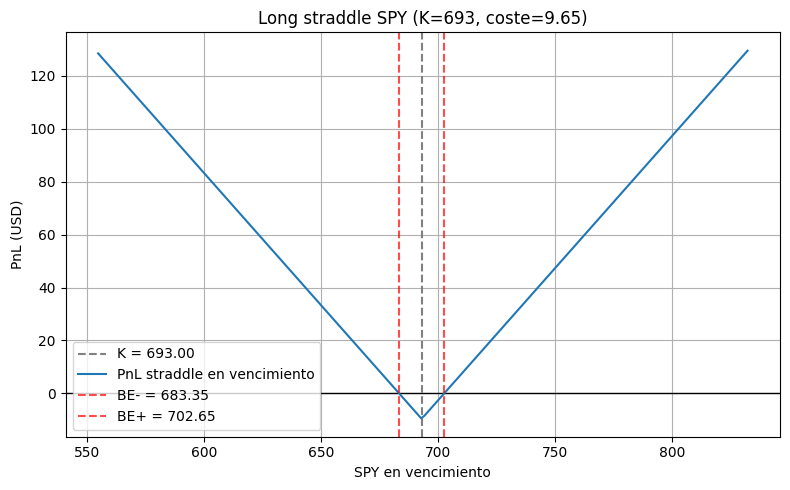

In [125]:
util.startLoop()

if __name__ == "__main__":
    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497
    CLIENT_ID = 1

    ib = IB()
    spy = Stock("SPY", "SMART", "USD")

    # -------------------------
    # 1) Conexión IBKR
    # -------------------------
    try:
        print("Conectando...")

        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)
    except Exception as e:
        print(f"Error conectando a IBKR: {e}")
        raise

    ib.qualifyContracts(spy)
    # -------------------------
    # 2) Precio spot desde CSV
    # -------------------------
    df_prices = pd.read_csv("Prices.csv")
    df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m-%d-%y")
    df_prices = df_prices.sort_values("Date")

    S = df_prices["Close"].iloc[-1]
    print(f"SPY spot (S) desde archivo: {S:.4f}")

    if S <= 0:
        raise RuntimeError("No se pudo obtener precio del SPY.")

    # -------------------------
    # 3) Cargar cadena desde CSV (tus datos)
    # -------------------------
    df = pd.read_csv("data.csv")

    # Función para limpiar bid/ask
    def parse_bid_ask(s):
        try:
            bid, ask = s.split(" x ")
            bid = float(bid) if bid.strip() not in ["", "x"] else float("nan")
            ask = float(ask) if ask.strip() not in ["", "x"] else float("nan")
            return bid, ask
        except:
            return float("nan"), float("nan")

    df["call_bid"], df["call_ask"] = zip(*df["CALL_BID x CALL_ASK"].apply(parse_bid_ask))
    df["put_bid"],  df["put_ask"]  = zip(*df["PUT_BID x PUT_ASK"].apply(parse_bid_ask))

    df["call_mid"] = (df["call_bid"] + df["call_ask"]) / 2
    df["put_mid"]  = (df["put_bid"]  + df["put_ask"])  / 2

    # -------------------------
    # 4) Expiry
    # -------------------------
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")

    # -------------------------
    # 5) Strike ATM desde tu CSV
    # -------------------------
    K = df.iloc[(df["EXERCISE"] - S).abs().argmin()]["EXERCISE"]
    row = df[df["EXERCISE"] == K].iloc[0]

    priceC = row["call_mid"]
    priceP = row["put_mid"]

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call mid price (CSV): {priceC}")
    print(f"Put  mid price (CSV): {priceP}")

    # -------------------------
    # 6) Calibración
    # -------------------------
    if not (math.isnan(priceC) or math.isnan(priceP)):
        r_calib = get_risk_free_rate_yahoo(default=0.045)
        q_calib = calculate_implied_q(S, K, T, r_calib, priceC, priceP)

        print("\n--- Calibración ---")
        print(f"r (Libre Riesgo): {r_calib:.2%}")
        print(f"q (Implied Yield): {q_calib:.2%}")
    else:
        print("ERROR: Faltan precios de opciones en el CSV.")

    # Coste total del straddle con tus precios mid, comprando 1 Call + 1 Put -> este es el valor máximo de pérdida si el subyacente no se mueve, acaba en Strike K y no hay comisiones
    STRADDLE_COST = priceC + priceP
    print(f"\nCoste total straddle (Call+Put): {STRADDLE_COST:.4f} USD")

    def payoff_straddle(ST, K, call_price, put_price):
        """
        Beneficio o perdida (PoL) del straddle en vencimiento:
        (payoff call + payoff put) - coste inicial
        payoff call = max(ST - K, 0)
        payoff put = max(K - ST, 0)

        Devuelve el PnL del straddle en función del precio del subyacente en vencimiento ST.
        """
        payoff_call = np.maximum(ST - K, 0.0)
        payoff_put = np.maximum(K - ST, 0.0)
        gross =  payoff_call + payoff_put
        return gross - (call_price + put_price)

    # Rango de precios posibles en vencimiento (por ejemplo ±20% alrededor de S)
    S_min = 0.8 * S
    S_max = 1.2 * S
    #Genera 200 precios posibles para ST, entre S_min y S_max, para evaluar el payoff en el rango
    ST_grid = np.linspace(S_min, S_max, 200)

    #Calcula el PnL del straddle en cada precio posible en vencimiento, un array de 200 valores de PnL
    pnl_grid = payoff_straddle(ST_grid, K, priceC, priceP)

    # Break-evens teóricos: K ± (coste total)
    breakeven_down = K - STRADDLE_COST #Inferior: el precio mínimo donde el straddle empieza a ganar
    breakeven_up   = K + STRADDLE_COST #Superior: el precio máximo donde el straddle empieza a ganar

    print(f"Break-even inferior: {breakeven_down:.4f}")
    print(f"Break-even superior: {breakeven_up:.4f}")

    # Plot del payoff/PnL en vencimiento
    plt.figure(figsize=(8, 5))
    plt.axhline(0, color="black", linewidth=1)
    plt.axvline(K, color="gray", linestyle="--", label=f"K = {K:.2f}")

    plt.plot(ST_grid, pnl_grid, label="PnL straddle en vencimiento")

    plt.axvline(breakeven_down, color="red", linestyle="--", alpha=0.7,
                label=f"BE- = {breakeven_down:.2f}")
    plt.axvline(breakeven_up, color="red", linestyle="--", alpha=0.7,
                label=f"BE+ = {breakeven_up:.2f}")

    plt.title(f"Long straddle SPY (K={K:.0f}, coste={STRADDLE_COST:.2f})")
    plt.xlabel("SPY en vencimiento")
    plt.ylabel("PnL (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    ib.disconnect()


PUNTO 2: Modificarla para obtener una versión delta-hedged (usando vuestras griegas) con el subyacente.

Conectando...
SPY spot (S) desde archivo: 693.5000
Expiry elegido: 20260213 | T (años aprox): 0.090411
Strike ATM (válido) K: 693.0000
Call mid price (CSV): 4.96
Put  mid price (CSV): 4.6899999999999995

--- Calibración ---
r (Libre Riesgo): 4.50%
q (Implied Yield): 4.87%

--- IV Europea (BS) ---
Call IV: 0.0583
Put  IV: 0.0583

Delta inicial del straddle: 0.0247


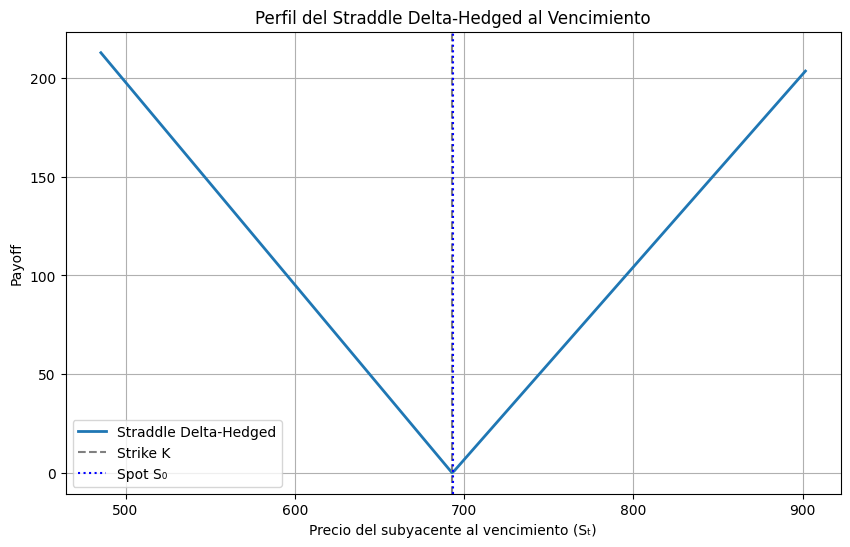

In [126]:
util.startLoop()

if __name__ == "__main__":

    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497
    CLIENT_ID = 5

    ib = IB()
    spy = Stock("SPY", "SMART", "USD")

    # -------------------------
    # 1) Conexión IBKR
    # -------------------------
    try:
        print("Conectando...")

        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)
    except Exception as e:
        print(f"Error conectando a IBKR: {e}")
        raise

    ib.qualifyContracts(spy)

    # -------------------------
    # 2) Precio spot desde CSV
    # -------------------------
    df_prices = pd.read_csv("Prices.csv")
    df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m-%d-%y")
    df_prices = df_prices.sort_values("Date")

    S = df_prices["Close"].iloc[-1]
    print(f"SPY spot (S) desde archivo: {S:.4f}")

    if S <= 0:
        raise RuntimeError("No se pudo obtener precio del SPY.")

    # -------------------------
    # 3) Cargar cadena desde CSV (tus datos)
    # -------------------------
    df = pd.read_csv("data.csv")

    # Función para limpiar bid/ask
    def parse_bid_ask(s):
        try:
            bid, ask = s.split(" x ")
            bid = float(bid) if bid.strip() not in ["", "x"] else float("nan")
            ask = float(ask) if ask.strip() not in ["", "x"] else float("nan")
            return bid, ask
        except:
            return float("nan"), float("nan")

    df["call_bid"], df["call_ask"] = zip(*df["CALL_BID x CALL_ASK"].apply(parse_bid_ask))
    df["put_bid"],  df["put_ask"]  = zip(*df["PUT_BID x PUT_ASK"].apply(parse_bid_ask))

    df["call_mid"] = (df["call_bid"] + df["call_ask"]) / 2
    df["put_mid"]  = (df["put_bid"]  + df["put_ask"])  / 2

    # -------------------------
    # 4) Expiry
    # -------------------------
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")

    # -------------------------
    # 5) Strike ATM desde tu CSV
    # -------------------------
    K = df.iloc[(df["EXERCISE"] - S).abs().argmin()]["EXERCISE"]
    row = df[df["EXERCISE"] == K].iloc[0]

    priceC = row["call_mid"]
    priceP = row["put_mid"]

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call mid price (CSV): {priceC}")
    print(f"Put  mid price (CSV): {priceP}")

    # -------------------------
    # 6) Calibración
    # -------------------------
    if not (math.isnan(priceC) or math.isnan(priceP)):
        r_calib = get_risk_free_rate_yahoo(default=0.045)
        q_calib = calculate_implied_q(S, K, T, r_calib, priceC, priceP)

        print("\n--- Calibración ---")
        print(f"r (Libre Riesgo): {r_calib:.2%}")
        print(f"q (Implied Yield): {q_calib:.2%}")
    else:
        print("ERROR: Faltan precios de opciones en el CSV.")

    # -----------------------------------------
    # 7) Calibración de IV usando tu función americana
    # -----------------------------------------

    sigma_call = implied_vol_bs(priceC, S, K, T, r_calib, q_calib, "C")
    sigma_put  = implied_vol_bs(priceP, S, K, T, r_calib, q_calib, "P")


    print("\n--- IV Europea (BS) ---")
    print(f"Call IV: {sigma_call:.4f}")
    print(f"Put  IV: {sigma_put:.4f}")

    if not (math.isfinite(sigma_call) and math.isfinite(sigma_put)):
        raise RuntimeError("No se pudo calibrar IV europea (Black-Scholes).")

    # -----------------------------------------
    # 8) Perfil del Straddle Delta-Hedged
    # -----------------------------------------

    # Delta inicial del straddle
    gC0 = bs_greeks_manual(S, K, T, r_calib, q_calib, sigma_call, "C")
    gP0 = bs_greeks_manual(S, K, T, r_calib, q_calib, sigma_put,  "P")
    delta0 = gC0["delta"] + gP0["delta"]

    print(f"\nDelta inicial del straddle: {delta0:.4f}")

    # Rango de precios para dibujar
    S_range = np.linspace(S * 0.7, S * 1.3, 300)

    # Payoff del straddle al vencimiento
    payoff_straddle = np.abs(S_range - K)

    # Payoff del hedge inicial (posición -delta0 en el subyacente)
    payoff_hedge = delta0 * (S_range - S)

    # Payoff delta-hedged
    payoff_delta_hedged = payoff_straddle - payoff_hedge

    # -----------------------------------------
    # Gráfico
    # -----------------------------------------
    plt.figure(figsize=(10,6))
    plt.plot(S_range, payoff_delta_hedged, label="Straddle Delta-Hedged", linewidth=2)
    plt.axvline(K, color="gray", linestyle="--", label="Strike K")
    plt.axvline(S, color="blue", linestyle=":", label="Spot S₀")
    plt.title("Perfil del Straddle Delta-Hedged al Vencimiento")
    plt.xlabel("Precio del subyacente al vencimiento (Sₜ)")
    plt.ylabel("Payoff")
    plt.grid(True)
    plt.legend()
    plt.show()


    ib.disconnect()

El valor de delta que me da es muy cercano a cero, por lo que el hedge es muy pequeño y el PnL delta-hedged es casi idéntico al del straddle sin cubrir. Esto es lógico, ya que un straddle es una estrategia diseñada para beneficiarse de movimientos significativos en el precio del subyacente, y su delta total suele ser cercano a cero cuando se compra.
Se notaría más la diferencia entre ambas estrategias si el straddle estuviera OTM o ITM, donde la delta total sería más significativa y el hedge tendría un impacto mayor en el PnL.

PUNTO 3: Analizar el P&L histórico de ambas versiones.

Es necesario reconstruir el comportamiento diario de ambas estrategias, long straddle y straddle delta-hedged, desde la fecha de compra hasta el vencimiento, usando los precios diarios del subyacente y las griegas iniciales. En el caso de delta-hedgeg se debe ajustar la posición en el subyacente diariamente.

P&L del straddle sin cubrir, se evalúa en vencimiento.
        PnL_straddle=max(S_T-K,0)+ max (K-S_T,0)-(priceC+priceP)
Donde S_T es el precio de SPY en vencimiento.

P&L del straddle delta-hedged (histórico), simulación diaria:
a) Inicial:
- Compras call y put ATM
- Calculas delta total: Delta =Delta_Call+Delta_Put
- Tomas posición en SPY: -Delta *número_de_contratos
b) Cada día:
- Calculas cambio en precio de SPY: Delta_S_t=S_t-S_t-1
- PnL del hedge: posición_SPY * Delta_S_t
- Acumulas PnL diario
c) En vencimiento:
- Añades payoff de opciones como en el straddle sin cubrir
- Sumas todos los PnL diarios del hedge



Conectando...
SPY spot (S) desde archivo: 693.5000
Expiry elegido: 20260213 | T (años aprox): 0.090411
Strike ATM (válido) K: 693.0000
Call mid price (CSV): 4.96
Put  mid price (CSV): 4.6899999999999995

--- Calibración ---
r (Libre Riesgo): 4.50%
q (Implied Yield): 4.87%

Delta Call (ATM): 0.51
Delta Put  (ATM): -0.499

Spot final (S_T): 693.5000
Coste total del straddle: 9.6500 USD

--- P&L Straddle sin cubrir en vencimiento ---
Payoff call:   0.5000
Payoff put:    0.0000
Payoff total:  0.5000
PnL straddle:  -9.1500 USD

--- Check rápido evolución histórica ---
         Date   Close  T_remaining  straddle_theo  PnL_straddle_hist
57 2025-12-31  681.92     0.120548      14.534415           4.884415
58 2026-01-02  683.17     0.115068      13.647834           3.997834
59 2026-01-05  687.72     0.106849      11.352560           1.702560
60 2026-01-06  691.81     0.104110      10.397791           0.747791
61 2026-01-07  693.50     0.101370      10.212152           0.562152

--- Check rápid

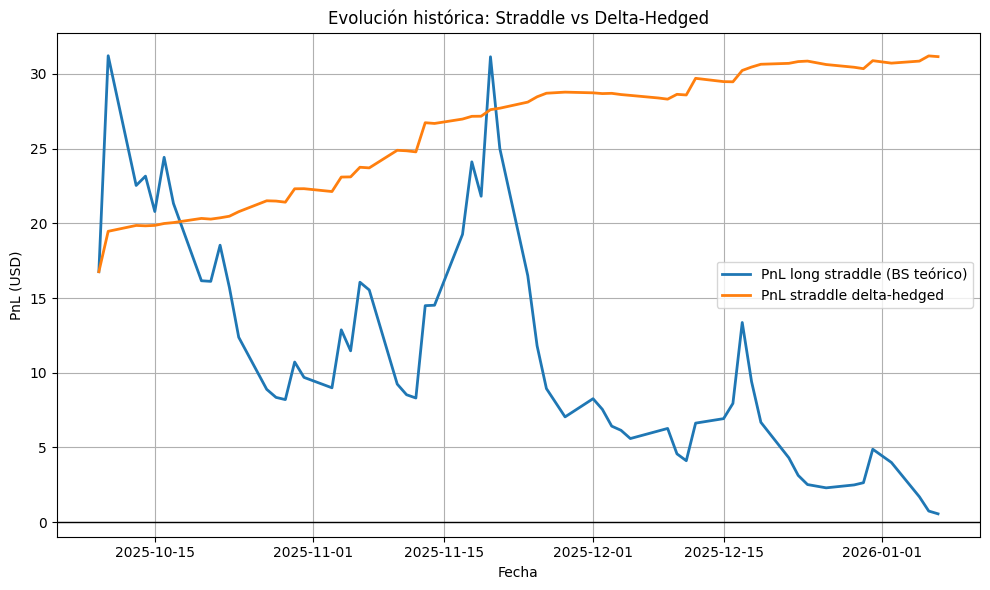

In [127]:
util.startLoop()

if __name__ == "__main__":
    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497
    CLIENT_ID = 9

    ib = IB()
    spy = Stock("SPY", "SMART", "USD")

    # -------------------------
    # 1) Conexión IBKR
    # -------------------------
    try:
        print("Conectando...")

        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)
    except Exception as e:
        print(f"Error conectando a IBKR: {e}")
        raise

    ib.qualifyContracts(spy)

    # -------------------------
    # 2) Precio spot desde CSV
    # -------------------------
    df_prices = pd.read_csv("Prices.csv")
    df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m-%d-%y")
    df_prices = df_prices.sort_values("Date")

    S = df_prices["Close"].iloc[-1]
    print(f"SPY spot (S) desde archivo: {S:.4f}")

    if S <= 0:
        raise RuntimeError("No se pudo obtener precio del SPY.")

    # -------------------------
    # 3) Cargar cadena desde CSV (tus datos)
    # -------------------------
    df = pd.read_csv("data.csv")

    # Función para limpiar bid/ask
    def parse_bid_ask(s):
        try:
            bid, ask = s.split(" x ")
            bid = float(bid) if bid.strip() not in ["", "x"] else float("nan")
            ask = float(ask) if ask.strip() not in ["", "x"] else float("nan")
            return bid, ask
        except:
            return float("nan"), float("nan")

    df["call_bid"], df["call_ask"] = zip(*df["CALL_BID x CALL_ASK"].apply(parse_bid_ask))
    df["put_bid"],  df["put_ask"]  = zip(*df["PUT_BID x PUT_ASK"].apply(parse_bid_ask))

    df["call_mid"] = (df["call_bid"] + df["call_ask"]) / 2
    df["put_mid"]  = (df["put_bid"]  + df["put_ask"])  / 2

    # -------------------------
    # 4) Expiry
    # -------------------------
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")

    # -------------------------
    # 5) Strike ATM desde tu CSV
    # -------------------------
    K = df.iloc[(df["EXERCISE"] - S).abs().argmin()]["EXERCISE"]
    row = df[df["EXERCISE"] == K].iloc[0]

    priceC = row["call_mid"]
    priceP = row["put_mid"]

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call mid price (CSV): {priceC}")
    print(f"Put  mid price (CSV): {priceP}")

    # -------------------------
    # 6) Calibración
    # -------------------------
    if not (math.isnan(priceC) or math.isnan(priceP)):
        r_calib = get_risk_free_rate_yahoo(default=0.045)
        q_calib = calculate_implied_q(S, K, T, r_calib, priceC, priceP)

        print("\n--- Calibración ---")
        print(f"r (Libre Riesgo): {r_calib:.2%}")
        print(f"q (Implied Yield): {q_calib:.2%}")
    else:
        print("ERROR: Faltan precios de opciones en el CSV.")

    ivC_bs = implied_vol_bisect(priceC, S, K, T, r_calib, q_calib, "C")
    ivP_bs = implied_vol_bisect(priceP, S, K, T, r_calib, q_calib, "P")

    # =====================================================
    # DELTA-HEDGED DEL STRADDLE
    # =====================================================

    # 1) Obtener deltas desde tu CSV (fila ATM)
    delta_call = float(row["CALL_DELTA"])
    delta_put  = float(row["PUT_DELTA"])

    print(f"\nDelta Call (ATM): {delta_call}")
    print(f"Delta Put  (ATM): {delta_put}")

    # =====================================================
    # 7) P&L DEL STRADDLE SIN CUBRIR EN VENCIMIENTO
    # =====================================================

    # Precio final del subyacente (último valor del CSV)
    S_T = df_prices["Close"].iloc[-1]
    print(f"\nSpot final (S_T): {S_T:.4f}")

    # Coste total del straddle
    straddle_cost = priceC + priceP
    print(f"Coste total del straddle: {straddle_cost:.4f} USD")

    # Payoff en vencimiento
    payoff_call = max(S_T - K, 0)
    payoff_put  = max(K - S_T, 0)
    payoff_total = payoff_call + payoff_put

    # PnL del straddle sin cubrir
    pnl_straddle = payoff_total - straddle_cost

    print("\n--- P&L Straddle sin cubrir en vencimiento ---")
    print(f"Payoff call:   {payoff_call:.4f}")
    print(f"Payoff put:    {payoff_put:.4f}")
    print(f"Payoff total:  {payoff_total:.4f}")
    print(f"PnL straddle:  {pnl_straddle:.4f} USD")


    # =====================================================
    # 8) EVOLUCIÓN HISTÓRICA DEL LONG STRADDLE (BLACK-SCHOLES)
    # =====================================================

    # Nos quedamos solo con las fechas hasta el vencimiento teórico
    expiry_date = datetime.strptime(expiry, "%Y%m%d")
    df_hist = df_prices[df_prices["Date"] <= expiry_date].copy()
    df_hist = df_hist.reset_index(drop=True)

    # Tiempo a vencimiento diario (en años) para cada fecha
    df_hist["T_remaining"] = (expiry_date - df_hist["Date"]).dt.days / 365.0

    # Coste inicial del straddle (referencia para el PnL)
    straddle_cost = priceC + priceP

    # Valor teórico diario de la call y la put con IV constante (ivC_bs, ivP_bs)
    df_hist["call_theo"] = df_hist.apply(
        lambda row: bs_price(
            S=row["Close"],
            K=K,
            T=row["T_remaining"],
            r=r_calib,
            q=q_calib,
            sigma=ivC_bs,
            right="C"
        ),
        axis=1
    )

    df_hist["put_theo"] = df_hist.apply(
        lambda row: bs_price(
            S=row["Close"],
            K=K,
            T=row["T_remaining"],
            r=r_calib,
            q=q_calib,
            sigma=ivP_bs,
            right="P"
        ),
        axis=1
    )

    # Valor teórico del straddle cada día
    df_hist["straddle_theo"] = df_hist["call_theo"] + df_hist["put_theo"]

    # PnL histórico del straddle (valor teórico - coste inicial)
    df_hist["PnL_straddle_hist"] = df_hist["straddle_theo"] - straddle_cost

    print("\n--- Check rápido evolución histórica ---")
    print(df_hist[["Date", "Close", "T_remaining", "straddle_theo", "PnL_straddle_hist"]].tail())

    # =====================================================
    # 10) EVOLUCIÓN HISTÓRICA DEL STRADDLE DELTA-HEDGED (DINÁMICO)
    # =====================================================

    # Inicializamos variables de estado
    hedge_pos = 0.0      # Acciones en cartera (short delta)
    hedge_pnl_cum = 0.0  # P&L acumulado del hedge
    prev_S = df_hist.iloc[0]["Close"]

    for i, row_hist in df_hist.iterrows():
        S_t = row_hist["Close"]
        T_t = max(row_hist["T_remaining"], 1e-6)

        # 1. Delta del straddle según BS (IV constante)
        gC = bs_greeks_manual(S_t, K, T_t, r_calib, q_calib, ivC_bs, "C")
        gP = bs_greeks_manual(S_t, K, T_t, r_calib, q_calib, ivP_bs, "P")
        delta_straddle = gC["delta"] + gP["delta"]

        # 2. CALCULO DE P&L (CORREGIDO)
        # El P&L de hoy es la posición que traíamos de ayer multiplicada por el cambio de precio
        if i > 0:
            dS = S_t - prev_S
            daily_hedge_pnl = hedge_pos * dS
            hedge_pnl_cum += daily_hedge_pnl

        # 3. REBALANCEO (Para la siguiente iteración)
        # Nuestra posición en acciones debe ser la opuesta al delta del straddle
        hedge_pos = -delta_straddle
        prev_S = S_t

        # 4. Guardar resultados en el DataFrame
        df_hist.at[i, "Delta_straddle"] = delta_straddle
        df_hist.at[i, "Hedge_pos"] = hedge_pos
        df_hist.at[i, "PnL_hedge_cum"] = hedge_pnl_cum

        # PnL total delta-hedged = PnL straddle (teórico) + PnL hedge acumulado
        df_hist.at[i, "PnL_delta_hedged"] = df_hist.at[i, "PnL_straddle_hist"] + hedge_pnl_cum

    print("\n--- Check rápido delta-hedged (dinámico) ---")
    print(df_hist[["Date", "Close", "Delta_straddle", "Hedge_pos",
               "PnL_hedge_cum", "PnL_straddle_hist", "PnL_delta_hedged"]].tail())


    # =====================================================
    # 11) GRÁFICO: STRADDLE vs DELTA-HEDGED
    # =====================================================
    plt.figure(figsize=(10, 6))
    plt.plot(df_hist["Date"], df_hist["PnL_straddle_hist"], label="PnL long straddle (BS teórico)", linewidth=2)
   # plt.plot(df_hist["Date"], df_hist["PnL_hedge_cum"], label="PnL hedge acumulado", linestyle="--", linewidth=2)
    plt.plot(df_hist["Date"], df_hist["PnL_delta_hedged"], label="PnL straddle delta-hedged", linewidth=2)

    plt.axhline(0, color="black", linewidth=1)
    plt.title("Evolución histórica: Straddle vs Delta-Hedged")
    plt.xlabel("Fecha")
    plt.ylabel("PnL (USD)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    ib.disconnect()

PnL straddle sin cubrir se mantiene plano hasta el vencimiento, cuando salta el payoff; en este caso una perdida igual al coste inicial porque el spot final es igual al strike.
PnL del hedge acumulado varía diariamente según los movimientos del subyacente, mostrando ganancias y pérdidas a lo largo del tiempo.


✔️ Si el subyacente se mantuvo cerca del strike
→ el straddle pierde por theta
→ el hedge no compensa
→ el PnL delta‑hedged es negativo
✔️ Si la volatilidad realizada fue menor que la implícita
→ el straddle estaba “caro”
→ no hubo suficiente movimiento para compensar
→ el delta‑hedged pierde
✔️ Si el rebalanceo fue costoso (muchos cambios de delta)
→ cada ajuste de hedge cuesta dinero
→ el PnL acumulado del hedge puede ser negativo
→ el total delta‑hedged baja


PUNTO 4: Simular envío de órdenes: como combo (straddle como una sola orden), y como patas sueltas (call y put por separado) analizando el riesgo de legging.

- Orden combo (straddle)
    - Envías una única orden de compra de straddle (combo call+put).
    - Se ejecuta a un precio único P_{\mathrm{combo}}.
    - No tienes riesgo de quedarte “coja”: o te llenan ambas patas, o nada.
- Patas sueltas (legging)
    - Compras call primero, luego put (o al revés).
    - Entre una y otra, el subyacente se mueve.
    - Te quedas un rato con delta ≠ 0 → riesgo direccional puro.


In [139]:
def simulate_straddle_orders(ib, spy_contract, strike, expiry):
    print("\n--- Iniciando Simulación de Órdenes ---")

    # 1. Definir los contratos de las patas
    call = Option('SPY', expiry, strike, 'C', 'SMART', currency='USD')
    put = Option('SPY', expiry, strike, 'P', 'SMART', currency='USD')

    # Es OBLIGATORIO calificar para obtener los conId antes de armar el Combo
    contracts = ib.qualifyContracts(call, put)
    if not contracts:
        print("Error: No se pudieron calificar los contratos de opciones.")
        return

    # ---------------------------------------------------------
    # ENVIAR COMO COMBO (Orden Única)
    # ---------------------------------------------------------
    print("\nEnviando Straddle como COMBO (BAG)...")

    straddle_bag = Contract()
    straddle_bag.symbol = 'SPY'
    straddle_bag.secType = 'BAG'
    straddle_bag.currency = 'USD'
    straddle_bag.exchange = 'SMART'

    # Definimos las patas del combo
    leg1 = ComboLeg(conId=call.conId, ratio=1, action='BUY', exchange='SMART')
    leg2 = ComboLeg(conId=put.conId, ratio=1, action='BUY', exchange='SMART')
    straddle_bag.comboLegs = [leg1, leg2]

    # En cuenta demo, usamos MarketOrder para asegurar ejecución rápida en la simulación
    # O LimitOrder si quieres probar el llenado parcial
    combo_order = MarketOrder(action='BUY', totalQuantity=1)

    # ib.whatIfOrder permite ver el margen sin ejecutar realmente,
    # pero para simular ejecución en Paper usaremos placeOrder
    trade_combo = ib.placeOrder(straddle_bag, combo_order)
    print(f"Orden Combo enviada. Status inicial: {trade_combo.orderStatus.status}")

#    # ---------------------------------------------------------
#    # OPCIÓN B: ENVIAR POR PATAS (Legging) + ANÁLISIS RIESGO
#    # ---------------------------------------------------------
#    print("\n[B] Iniciando ejecución por patas (Legging Risk Analysis)...")
#
#    # Paso 1: Comprar la Call
#    print("Ejecutando Pata 1: CALL...")
#    call_order = MarketOrder(action='BUY', totalQuantity=1)
#    trade_call = ib.placeOrder(call, call_order)
#
#    # Simulamos un pequeño retraso de mercado o latencia de red (2 segundos)
#    # Aquí es donde el precio del SPY podría moverse y arruinar el Straddle
#    ib.sleep(2)
#
#    # Paso 2: Comprar la Put
#    print("Ejecutando Pata 2: PUT...")
#    put_order = MarketOrder(action='BUY', totalQuantity=1)
#    trade_put = ib.placeOrder(put, put_order)
#
#    # Esperamos a que se llenen (en demo suele ser instantáneo)
#    while not (trade_call.isDone() and trade_put.isDone()):
#        ib.sleep(0.5)
#
#    # ANALISIS DE RIESGO DE LEGGING
#    cost_call = trade_call.orderStatus.avgFillPrice
#    cost_put = trade_put.orderStatus.avgFillPrice
#    total_legs_cost = cost_call + cost_put
#
#    # Obtenemos el precio del combo para comparar
#    # (En un entorno real, compararíamos contra el Mid-Price del Combo en T0)
#    print("\n--- RESULTADO DEL ANÁLISIS DE RIESGO ---")
#    print(f"Precio ejecución CALL: {cost_call:.2f}")
#    print(f"Precio ejecución PUT:  {cost_put:.2f}")
#    print(f"Coste Total Legging:   {total_legs_cost:.2f}")
#
#    # Si el precio del SPY se movió mucho en esos 2 segundos, el coste de la Put habrá cambiado respecto al momento en que compraste la Call.
#
#    if trade_combo.avgFillPrice > 0:
#        diff = total_legs_cost - trade_combo.avgFillPrice
#        print(f"Diferencia (Legging vs Combo): {diff:.2f} USD")
#        if diff > 0:
#            print("El Legging resultó más caro que el Combo.")
#        else:
#            print("El Legging resultó más barato (pudo haber suerte con el movimiento del spot).")

    return (trade_combo)
            #trade_call, trade_put)


In [142]:
util.startLoop()

if __name__ == "__main__":
    ensure_ipython_loop()

    HOST = "127.0.0.1"
    PORT = 7497
    CLIENT_ID = 17

    ib = IB()
    spy = Stock("SPY", "SMART", "USD")

    # -------------------------
    # 1) Conexión IBKR
    # -------------------------
    try:
        print("Conectando...")

        ib.connect(HOST, PORT, clientId=CLIENT_ID)
        ib.reqMarketDataType(3)
    except Exception as e:
        print(f"Error conectando a IBKR: {e}")
        raise

    ib.qualifyContracts(spy)
    ib.reqMarketDataType(3)
    # -------------------------
    # 2) Precio spot desde CSV
    # -------------------------
    df_prices = pd.read_csv("Prices.csv")
    df_prices["Date"] = pd.to_datetime(df_prices["Date"], format="%m-%d-%y")
    df_prices = df_prices.sort_values("Date")

    S = df_prices["Close"].iloc[-1]
    print(f"SPY spot (S) desde archivo: {S:.4f}")

    if S <= 0:
        raise RuntimeError("No se pudo obtener precio del SPY.")

    # -------------------------
    # 3) Cargar cadena desde CSV (tus datos)
    # -------------------------
    df = pd.read_csv("data.csv")

    # Función para limpiar bid/ask
    def parse_bid_ask(s):
        try:
            bid, ask = s.split(" x ")
            bid = float(bid) if bid.strip() not in ["", "x"] else float("nan")
            ask = float(ask) if ask.strip() not in ["", "x"] else float("nan")
            return bid, ask
        except:
            return float("nan"), float("nan")

    df["call_bid"], df["call_ask"] = zip(*df["CALL_BID x CALL_ASK"].apply(parse_bid_ask))
    df["put_bid"],  df["put_ask"]  = zip(*df["PUT_BID x PUT_ASK"].apply(parse_bid_ask))

    df["call_mid"] = (df["call_bid"] + df["call_ask"]) / 2
    df["put_mid"]  = (df["put_bid"]  + df["put_ask"])  / 2

    # -------------------------
    # 4) Expiry
    # -------------------------
    chains = ib.reqSecDefOptParams("SPY", "", "STK", spy.conId)
    chain = next(c for c in chains if c.exchange == "SMART" and c.tradingClass == "SPY")

    expirations = sorted(chain.expirations)
    strikes = sorted(chain.strikes)

    expiry = pick_expiry_target(expirations, target_days=30)
    T = yearfrac_from_yyyymmdd(expiry)

    print(f"Expiry elegido: {expiry} | T (años aprox): {T:.6f}")

    # -------------------------
    # 5) Strike ATM desde tu CSV
    # -------------------------
    K = df.iloc[(df["EXERCISE"] - S).abs().argmin()]["EXERCISE"]
    row = df[df["EXERCISE"] == K].iloc[0]

    priceC = row["call_mid"]
    priceP = row["put_mid"]

    print(f"Strike ATM (válido) K: {K:.4f}")
    print(f"Call mid price (CSV): {priceC}")
    print(f"Put  mid price (CSV): {priceP}")

    # -------------------------
    # 6) Calibración
    # -------------------------
    if not (math.isnan(priceC) or math.isnan(priceP)):
        r_calib = get_risk_free_rate_yahoo(default=0.045)
        q_calib = calculate_implied_q(S, K, T, r_calib, priceC, priceP)

        print("\n--- Calibración ---")
        print(f"r (Libre Riesgo): {r_calib:.2%}")
        print(f"q (Implied Yield): {q_calib:.2%}")
    else:
        print("ERROR: Faltan precios de opciones en el CSV.")

    simulate_straddle_orders(ib, spy, K, expiry)
    ib.disconnect()

Conectando...


positions request timed out
open orders request timed out
account updates for U23714765 request timed out


Error conectando a IBKR: 


TimeoutError: 

PUNTO 5: Ver cómo se puede neutralizar Delta con otra opción y qué implica para Gamma, Vega y Theta.

PUNTO 6: Reflexión: ¿qué habría cambiado usando SPX en lugar de SPY?